Import libraries

In [1]:
import os
import glob
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

Load images

In [2]:
def find_images(directory):
    images = []
    
    # Use glob to find all files ending with "_crop.png" in the current directory
    images.extend(glob.glob(os.path.join(directory, '*_crop.png')))

    return images

# List of 10 directories to search for the images
directories = [
    "dataset/calculator/calculator_1",
    "dataset/camera/camera_1",
    "dataset/cell_phone/cell_phone_1",
    "dataset/cereal_box/cereal_box_1",
    "dataset/dry_battery/dry_battery_1",
    "dataset/flashlight/flashlight_1",
    "dataset/garlic/garlic_1",
    "dataset/hand_towel/hand_towel_1",
    "dataset/instant_noodles/instant_noodles_1",
    "dataset/marker/marker_1"
]

objects = []

for i in range(10):   
    object = find_images(directories[i])
    objects.extend(object)


Split the dataset as 90% training and 10% test

In [3]:
# Split the images into 90% training and 10% test sets
train_images, test_images = train_test_split(objects, test_size=0.1, random_state=42)

Create 3 different feature detector and descriptors (SIFT, KAZE and BRISK) and a matcher.

In [4]:
# Initialize feature detectors and descriptors
sift = cv2.SIFT_create()
kaze = cv2.KAZE_create()
brisk = cv2.BRISK_create()

# BFMatcher with default params
bf = cv2.BFMatcher()

Get the keypoints and descriptors of the images. Handle None type descriptors as an empty descriptor.

In [5]:
def detect_and_compute(images, detector):
    keypoints = []
    descriptors = []
    count = 0
    for image in images:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img, None)
        keypoints.append(kp)
        if des is not None:
            descriptors.append(des)
        else:
            descriptors.append(np.empty((0, 64)))  # Append empty array if descriptor is None
            count += 1
            
    return keypoints, descriptors, count

Iterate over each test image and for each training image, use matcher to get the good matches between the current test image and the training image. Append the number of good matches for each training image and get the index of the best training image (having the most good matches) as a prediction. The corresponding training image will be the prediction of test image. Its label will be used to compute confusion matrix.

In [6]:
def match_and_predict(test_descriptors, train_descriptors, matcher):
    predictions = []
    for des_test in test_descriptors:
        best_matches = []
        for des_train in train_descriptors:
            
            if des_test.size == 0 or des_train.size == 0:  # Skip if descriptors are empty
                best_matches.append(0)
                continue
            
            matches = matcher.knnMatch(des_test, des_train, k=2) # Use matcher
            
            # Apply ratio test
            good_matches = []
            for m_n in matches:
                if len(m_n) == 2:  # Ensure that there are two matches
                    m, n = m_n
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)
                        
            best_matches.append(len(good_matches)) # Add the number of good matches
            
        best_match_index = np.argmax(best_matches) # Get the index of the best match 
        predictions.append(best_match_index)
    return predictions

Get the keypoints and descriptors with a None counter for SIFT, KAZE and BRISK 

In [7]:
keypoints_sift_train, descriptors_sift_train, count1 = detect_and_compute(train_images, sift)
keypoints_sift_test, descriptors_sift_test, count2 = detect_and_compute(test_images, sift)

keypoints_kaze_train, descriptors_kaze_train, count3 = detect_and_compute(train_images, kaze)
keypoints_kaze_test, descriptors_kaze_test, count4 = detect_and_compute(test_images, kaze)

keypoints_brisk_train, descriptors_brisk_train, count5 = detect_and_compute(train_images, brisk)
keypoints_brisk_test, descriptors_brisk_test, count6 = detect_and_compute(test_images, brisk)

Check the number of None descriptors. BRISK has a lot of None descriptors. This will affect the accuracy.

In [8]:
print(len(train_images))
print(len(test_images))

5966
663


In [9]:
print("Number of None occurrences in descriptors_sift_train:", count1)
print("Number of None occurrences in descriptors_sift_test:", count2)
print("Number of None occurrences in descriptors_kaze_train:", count3)
print("Number of None occurrences in descriptors_kaze_test:", count4)
print("Number of None occurrences in descriptors_brisk_train:", count5)
print("Number of None occurrences in descriptors_brisk_test:", count6)

Number of None occurrences in descriptors_sift_train: 0
Number of None occurrences in descriptors_sift_test: 0
Number of None occurrences in descriptors_kaze_train: 10
Number of None occurrences in descriptors_kaze_test: 0
Number of None occurrences in descriptors_brisk_train: 1478
Number of None occurrences in descriptors_brisk_test: 159


Extract the labels of the images to compute confusion matrix

In [10]:
def extract_labels(filenames, label_map):
    labels = []
    for filename in filenames:
        label = filename.split('/')[1]
        labels.append(label_map[label])
    return labels

Use this mapping for labels

In [11]:
label_map = {
    'calculator': 0,
    'camera': 1,
    'cell_phone': 2,
    'cereal_box': 3,
    'dry_battery': 4,
    'flashlight': 5,
    'garlic': 6,
    'hand_towel': 7,
    'instant_noodles': 8,
    'marker': 9
}

train_labels = extract_labels(train_images, label_map)
test_labels = extract_labels(test_images, label_map)

Get a sample from all classes

In [12]:
unique_classes = set(train_labels)
class_samples = {}

# Iterate over unique classes and find one sample for each class
for label in unique_classes:
    index = train_labels.index(label)
    class_samples[label] = index

# Print collected samples
for label, index in class_samples.items():
    print(f"Sample index for class {label}: {index}")
    
class_samples = list(class_samples.values())

Sample index for class 0: 6
Sample index for class 1: 1
Sample index for class 2: 0
Sample index for class 3: 10
Sample index for class 4: 7
Sample index for class 5: 15
Sample index for class 6: 5
Sample index for class 7: 3
Sample index for class 8: 4
Sample index for class 9: 24


Visualize the keypoints to see the detected features

dataset/calculator/calculator_1/calculator_1_2_107_crop.png


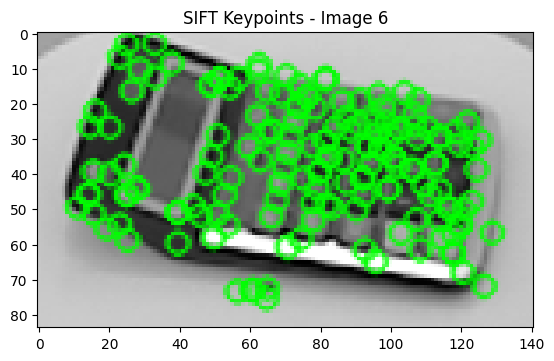

dataset/camera/camera_1/camera_1_2_182_crop.png


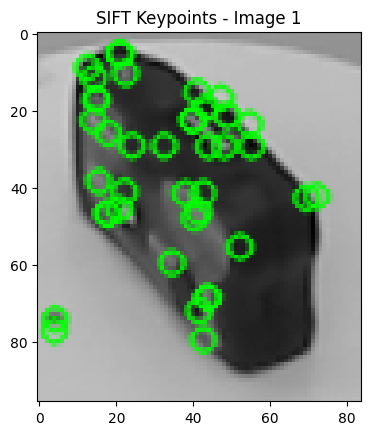

dataset/cell_phone/cell_phone_1/cell_phone_1_2_176_crop.png


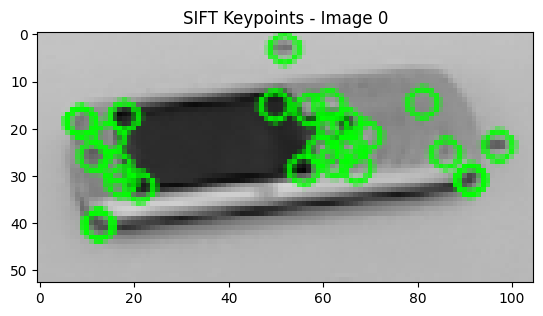

dataset/cereal_box/cereal_box_1/cereal_box_1_2_108_crop.png


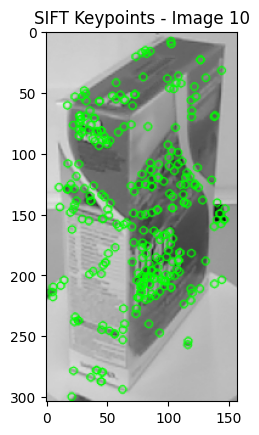

dataset/dry_battery/dry_battery_1/dry_battery_1_2_191_crop.png


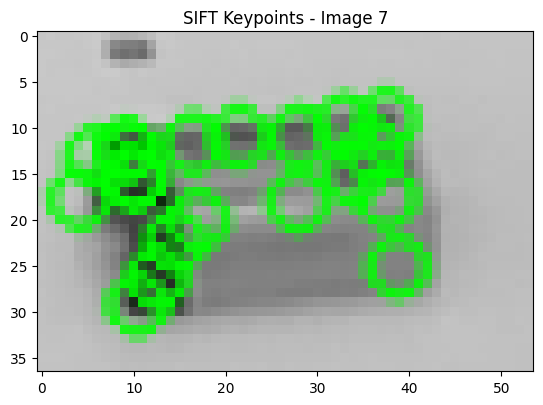

dataset/flashlight/flashlight_1/flashlight_1_2_124_crop.png


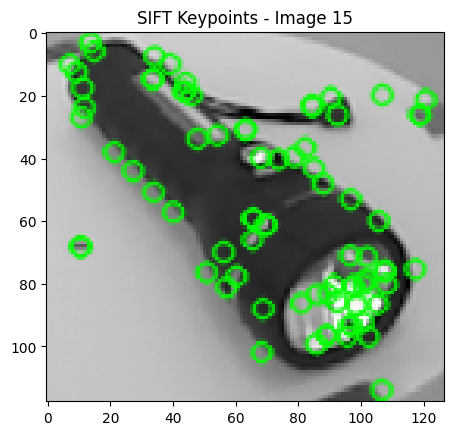

dataset/garlic/garlic_1/garlic_1_2_50_crop.png


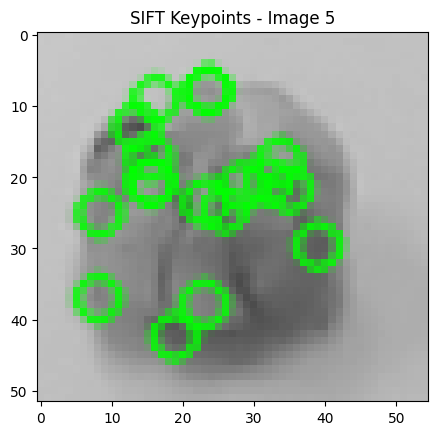

dataset/hand_towel/hand_towel_1/hand_towel_1_2_104_crop.png


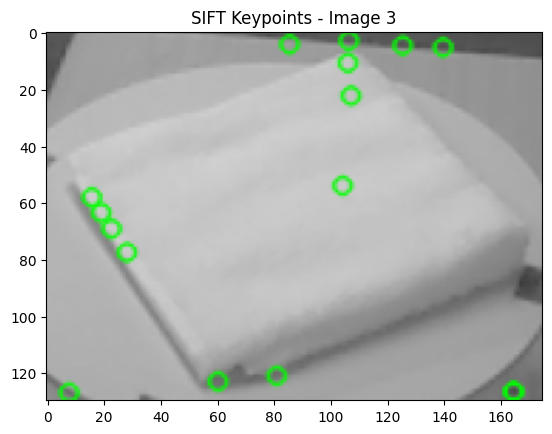

dataset/instant_noodles/instant_noodles_1/instant_noodles_1_4_91_crop.png


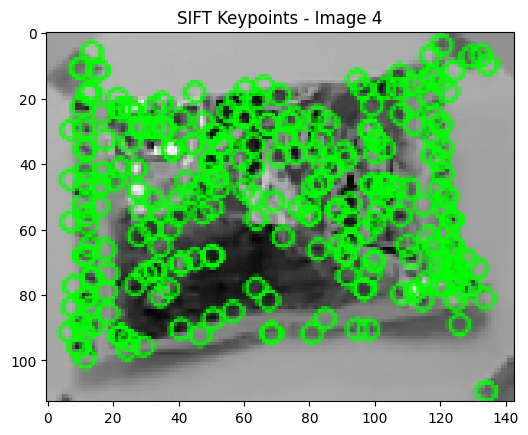

dataset/marker/marker_1/marker_1_4_107_crop.png


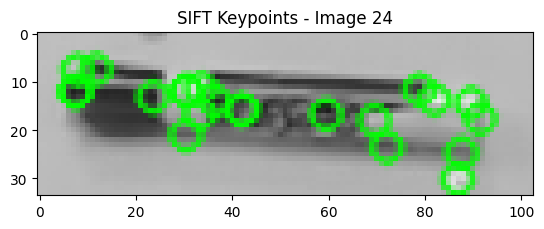

dataset/calculator/calculator_1/calculator_1_2_107_crop.png


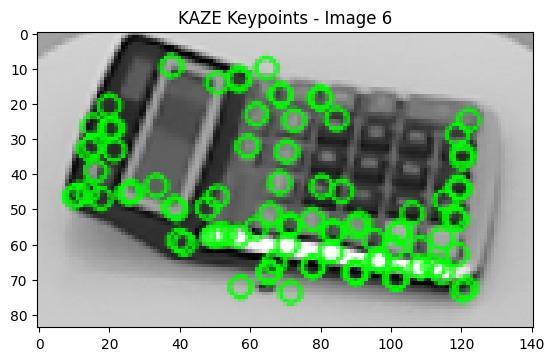

dataset/camera/camera_1/camera_1_2_182_crop.png


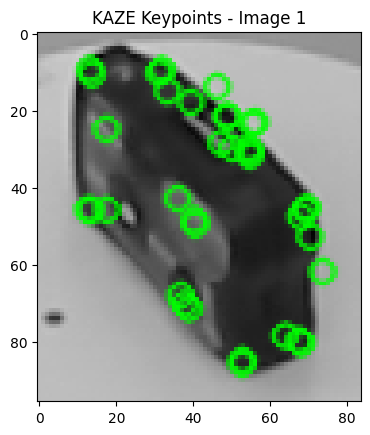

dataset/cell_phone/cell_phone_1/cell_phone_1_2_176_crop.png


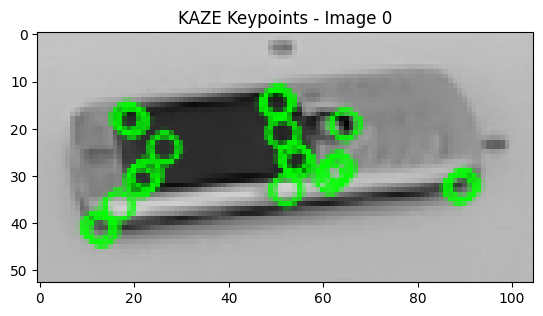

dataset/cereal_box/cereal_box_1/cereal_box_1_2_108_crop.png


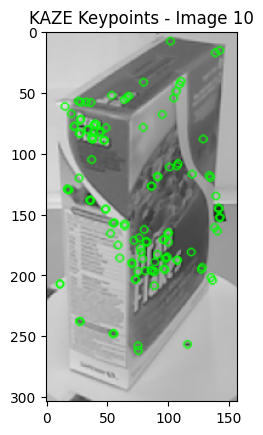

dataset/dry_battery/dry_battery_1/dry_battery_1_2_191_crop.png


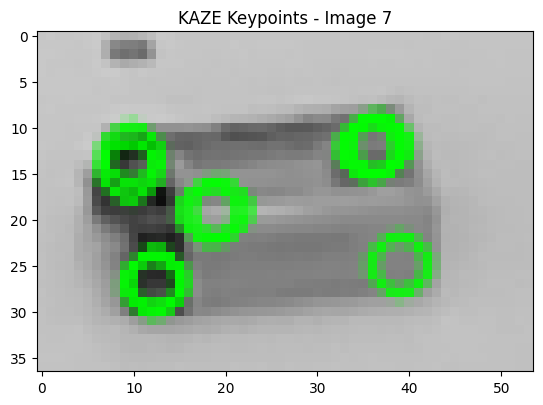

dataset/flashlight/flashlight_1/flashlight_1_2_124_crop.png


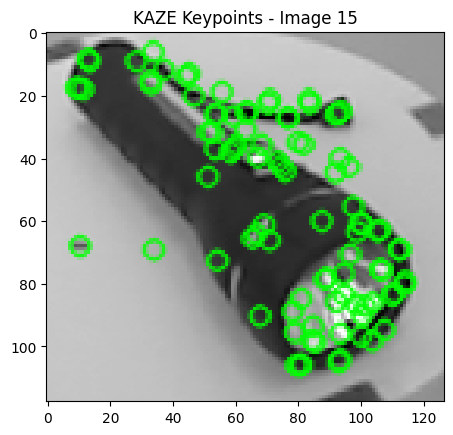

dataset/garlic/garlic_1/garlic_1_2_50_crop.png


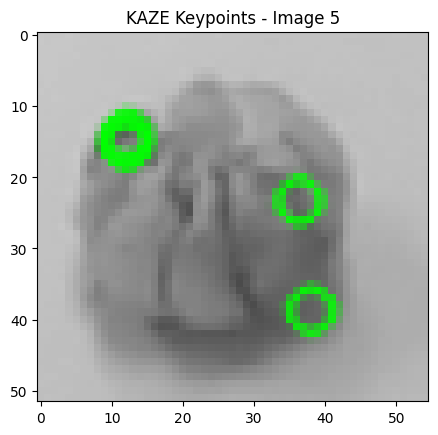

dataset/hand_towel/hand_towel_1/hand_towel_1_2_104_crop.png


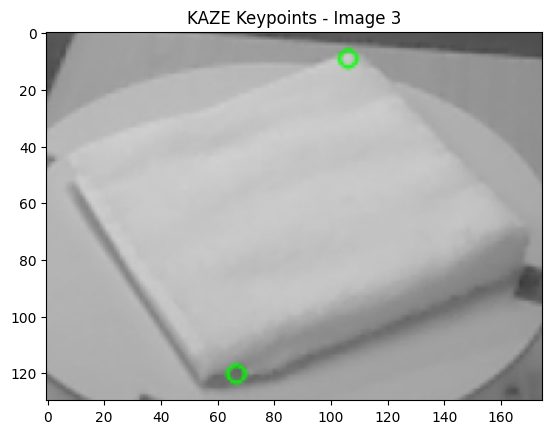

dataset/instant_noodles/instant_noodles_1/instant_noodles_1_4_91_crop.png


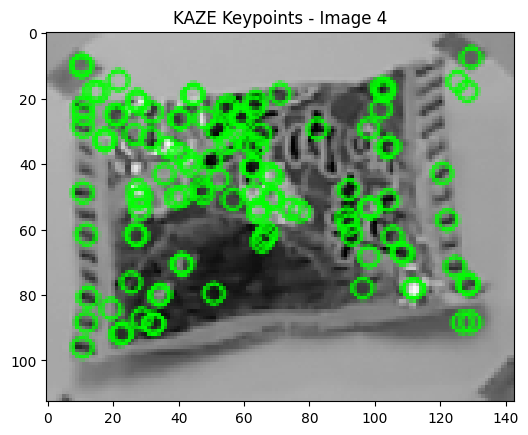

dataset/marker/marker_1/marker_1_4_107_crop.png


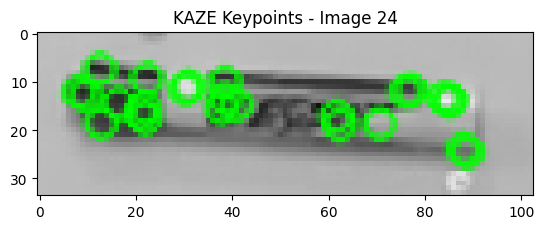

dataset/calculator/calculator_1/calculator_1_2_107_crop.png


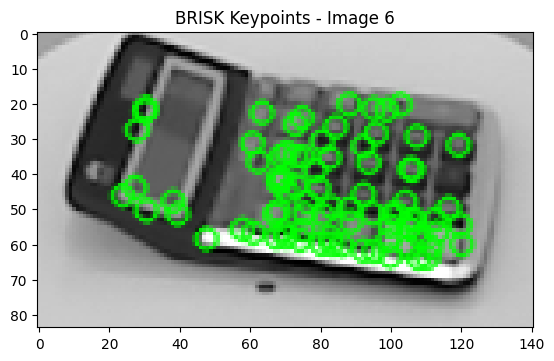

dataset/camera/camera_1/camera_1_2_182_crop.png


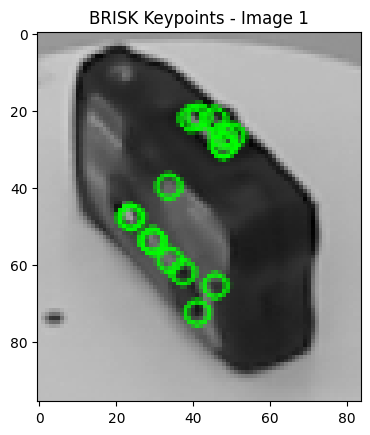

dataset/cell_phone/cell_phone_1/cell_phone_1_2_176_crop.png


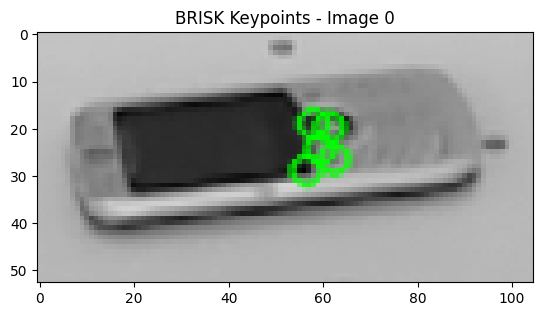

dataset/cereal_box/cereal_box_1/cereal_box_1_2_108_crop.png


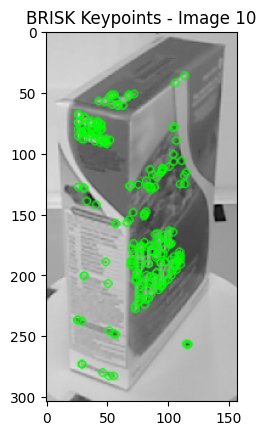

dataset/dry_battery/dry_battery_1/dry_battery_1_2_191_crop.png


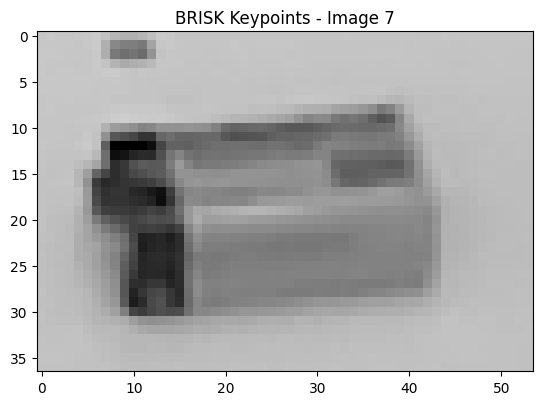

dataset/flashlight/flashlight_1/flashlight_1_2_124_crop.png


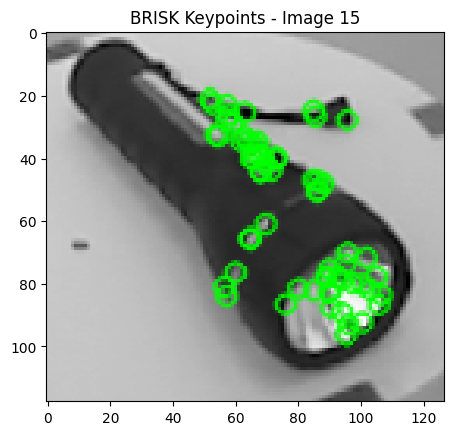

dataset/garlic/garlic_1/garlic_1_2_50_crop.png


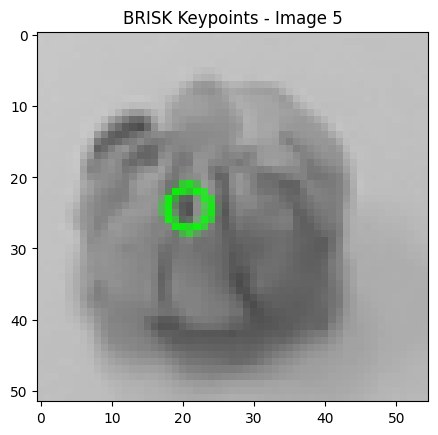

dataset/hand_towel/hand_towel_1/hand_towel_1_2_104_crop.png


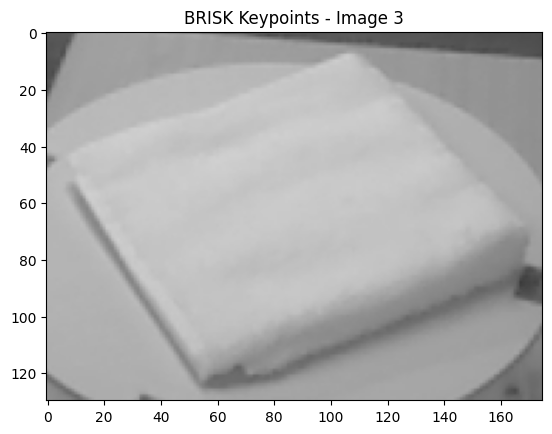

dataset/instant_noodles/instant_noodles_1/instant_noodles_1_4_91_crop.png


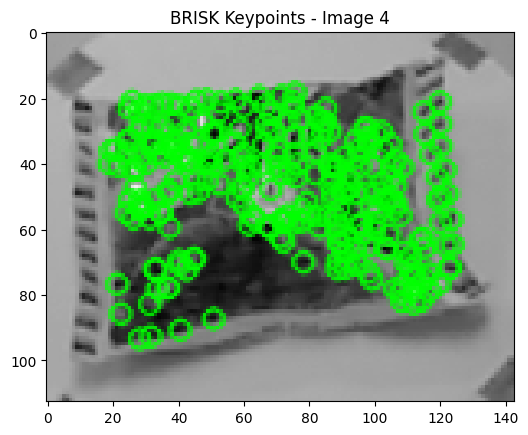

dataset/marker/marker_1/marker_1_4_107_crop.png


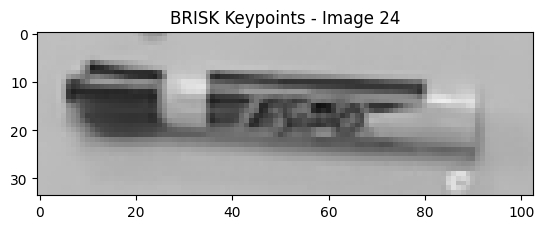

In [13]:
def visualize_keypoints(images, keypoints_list, indices, title):
    for index in indices:
        print(images[index])
        img = cv2.imread(images[index], cv2.IMREAD_GRAYSCALE)
        img = cv2.drawKeypoints(img, keypoints_list[index], None, color=(0, 255, 0))
        plt.imshow(img, cmap='gray')
        plt.title(f'{title} - Image {index}')
        plt.show()

visualize_keypoints(train_images, keypoints_sift_train, class_samples, 'SIFT Keypoints')
visualize_keypoints(train_images, keypoints_kaze_train, class_samples, 'KAZE Keypoints')
visualize_keypoints(train_images, keypoints_brisk_train, class_samples, 'BRISK Keypoints')

Get the predictions for each one

In [14]:
sift_predictions = match_and_predict(descriptors_sift_test, descriptors_sift_train, bf)
kaze_predictions = match_and_predict(descriptors_kaze_test, descriptors_kaze_train, bf)
brisk_predictions = match_and_predict(descriptors_brisk_test, descriptors_brisk_train, bf)

Compute the confusion matrices for each one.

In [15]:
sift_confusion_matrix = confusion_matrix(test_labels, [train_labels[index] for index in sift_predictions])
kaze_confusion_matrix = confusion_matrix(test_labels, [train_labels[index] for index in kaze_predictions])
brisk_confusion_matrix = confusion_matrix(test_labels, [train_labels[index] for index in brisk_predictions])

Plot the matrices

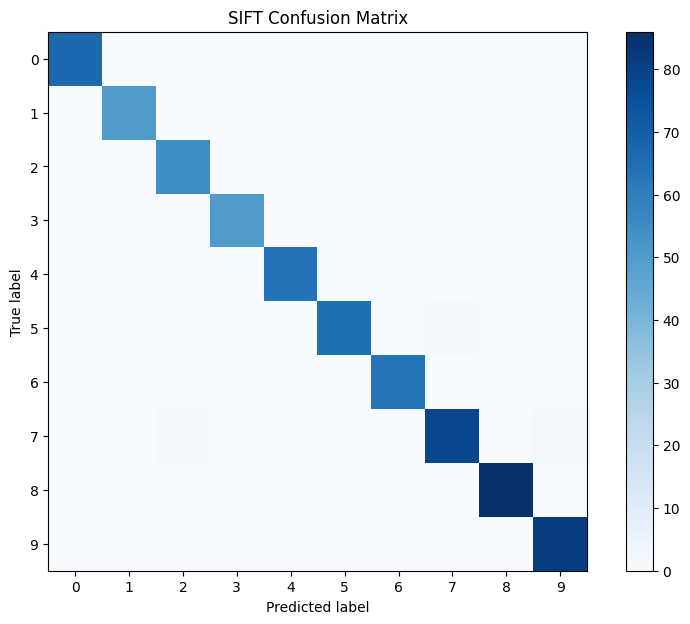

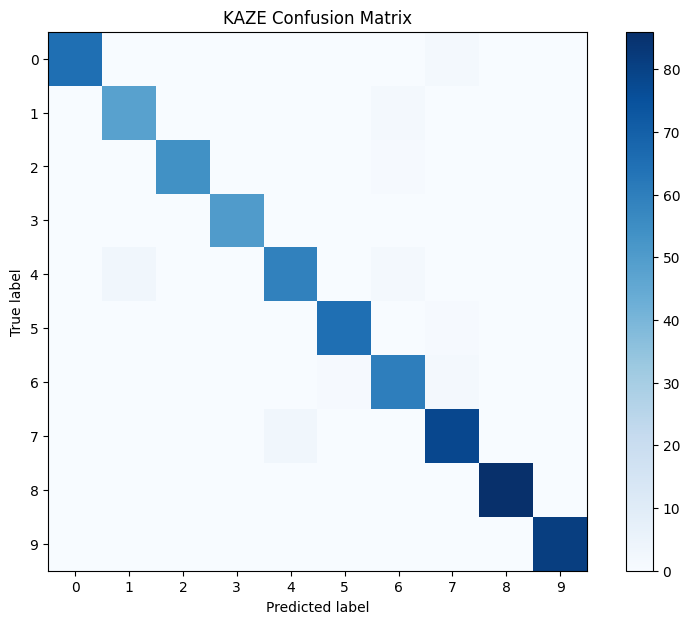

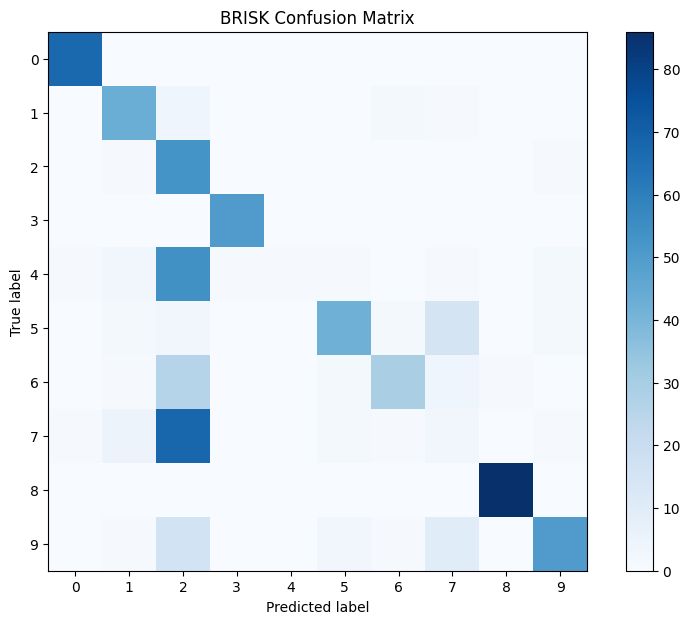

In [17]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(test_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(sift_confusion_matrix, 'SIFT Confusion Matrix')
plot_confusion_matrix(kaze_confusion_matrix, 'KAZE Confusion Matrix')
plot_confusion_matrix(brisk_confusion_matrix, 'BRISK Confusion Matrix')

The best result is from SIFT and also KAZE gives a good result. However, None descriptors affected BRISK's accuracy a lot.